## Learning Diffrential Equations from Time Series via RNN

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import matplotlib
import time
import random
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import mean_squared_error
import matplotlib.image as mpimg
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import mean_absolute_error
from keras.optimizers import SGD


Using TensorFlow backend.


In [2]:
def data_normalize(Dat):
    
    new_dat  = []
    for d in Dat:
        if len(set(d))==1:
            new_dat.append(d)
        else:
            min, max = np.min(d), np.max(d)
            a = max -min
            new_dat.append([(val - min)/a for val in d])
    return new_dat

def data_split(dat, train_hour, test_hour):
    X, Y = [], []
    period = train_hour + test_hour
    i = 0
    while i + period < len(dat[0]):
        x_temp = []
        y_temp = []
        for j in range(len(dat)):
            x_temp.append(dat[j][i:i + train_hour])
            y_temp.append(dat[j][i+train_hour:i+period])
        X.append(x_temp)
        Y.append(y_temp)
        i += train_hour
    return np.array(X), np.array(Y)



In [3]:
def flattern(p):
    pred_y_matrix = [[]for _ in range(len(p[0])) ]
    for pp in p:
        a = pp.tolist()
        #a = np.array(pp).T.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]
    return pred_y_matrix
def multi_heatmap(Test_y, Pred_y):
    Test_y = Test_y.reshape(Test_y.shape[0],Test_y.shape[1],Test_y.shape[2])
    Pred_y = Pred_y.reshape(Pred_y.shape[0],Pred_y.shape[1],Pred_y.shape[2])
    py = flattern(Pred_y)
    ty = flattern(Test_y)
    #Plot the new heatmap of predict data vs test data
    print(len(py),len(ty))
    hm_hour = sns.heatmap(ty)
    hm_hour.set_title('Test Data')
    plt.figure()
    plt.show()
    hm_hour = sns.heatmap(py)
    hm_hour.set_title('Predict Data')
    plt.figure()
    plt.show()
    mse_lis = []
    for i in range(len(py)):
        mse_lis.append(mean_squared_error(py[i], ty[i]))
    return mse_lis

In [4]:
def stacked_LSTM(X, Y):
    time_step = X.shape[1]
    input_dim = X.shape[2]
    out = Y.shape[2]
    #Bidirectional LSTM
    #opt = SGD(clipvalue=5)
    opt = optimizers.Adam(learning_rate=1e-6,clipvalue=.5)
    start = time.time()
    model = Sequential()
    #model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(64,activation='relu', input_shape=(time_step, input_dim),return_sequences=True)))
    model.add(Bidirectional(LSTM(32,activation='relu', input_shape=(time_step, input_dim),return_sequences=True)))
    #model.add(LSTM(64,activation='relu', input_shape=(time_step, input_dim),return_sequences=True))
    #model.add(LSTM(64,activation='re
    # lu', input_shape=(time_step, input_dim),return_sequences=True))
    model.add(Dense(out))
    model.compile(loss='mean_squared_error', optimizer='adam')
    hist = model.fit(X, Y,epochs=100, validation_split=.2,
              verbose=1, batch_size=1)
    model.summary()
    end = time.time()
    print("Total compile time: --------", end - start, 's')
    return model, hist

In [5]:
def DE_Learner(data, train_time, predict_time):
    data_x, data_y = data_split(data,train_time,predict_time )
    train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2)
    print('Whole data size(batch, row, column)',data_x.shape, data_y.shape)
    print('Train data size(batch, row, column)',train_x.shape, train_y.shape)
    print('test data size(batch, row, column)',test_x.shape, test_y.shape)
    model, hist = stacked_LSTM(train_x,train_y)
    pred_y = model.predict(test_x, verbose=1)
    error = multi_heatmap(test_y, pred_y)
    py = flattern(pred_y)
    ty = flattern(test_y)
    plt.figure()
    for j in range(len(ty)):
        plt.scatter(range(len(ty[j])),[ty[j][i]-py[j][i] for i in range(len(ty[j]))])
    plt.title('Test Errors')
    plt.ylim(-.5,.5)
    plt.figure()
    #plot loss history
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    print('mse: ', np.mean(error))
    py = np.array(py).T
    ty = np.array(ty).T
    return py, ty, error, model

#### 1D Wave Equation
$u_{tt} = cu_{xx}$

In [7]:
def u(x,t):
    return [0.5*(np.sin(4*np.pi*xi+t) + np.sin(4*np.pi*xi-t)) for xi in x ]
def wave(dx, dt, nx, nt ):
    T = dt*nt
    x0 = np.linspace(0,nx*dx,nx+1)
    wave_dat = [[]for _ in range(len(x0))]
    t0 = 0
    for i in range(nt):
        value = u(x0,t0)
        for j in range(len(wave_dat)):
            wave_dat[j].append(value[j])#+np.random.normal(0,.01))
            t0 +=dt
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.plot(x0,u(x0,0))
    ax1.set_title('Initial Condition')
    ax2 = fig.add_subplot(212)
    ax2.plot(x0,u(x0,T))
    ax2.set_title('Final State t=: '+str(T))
    plt.ylim(-1,1)
    plt.show()
    return wave_dat

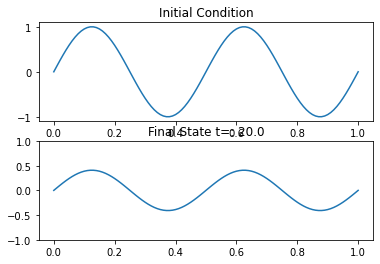

101 2000


In [8]:
dt = .01
dx = .01
nx = 100
nt = 2000
wave_dat = wave(dx,dt,nx,nt)
print(len(wave_dat),len(wave_dat[0]))

In [ ]:
# Run Deep Learning Model
# t1, t2 = 20, 10
# Dx = [.01,.05,.1,.2]
# mse = []
# for dx in Dx:
#     wave_dat = wave(dx,.01,100, 1000)
#     wave_py, wave_ty,wave_mse,wavemodel = DE_Learner(wave_dat,t1,t2)
#     mse.append(np.mean(wave_mse))

In [10]:
t1 = 30
t2 = 10

Whole data size(batch, row, column) (66, 101, 30) (66, 101, 10)
Train data size(batch, row, column) (52, 101, 30) (52, 101, 10)
test data size(batch, row, column) (14, 101, 30) (14, 101, 10)
Train on 41 samples, validate on 11 samples
Epoch 1/100
41/41 [==============================] - 7s 175ms/step - loss: 0.0632 - val_loss: 0.0086

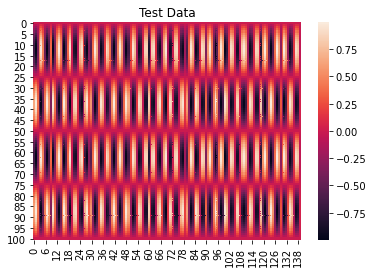

<Figure size 432x288 with 0 Axes>

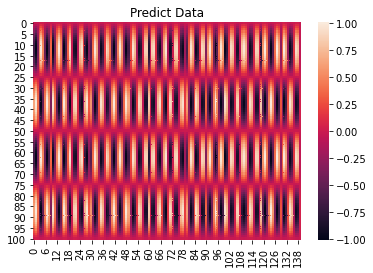

<Figure size 432x288 with 0 Axes>

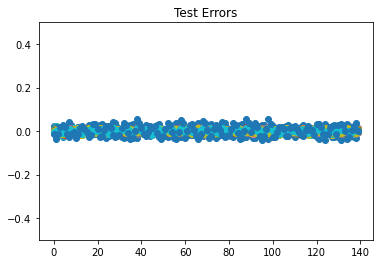

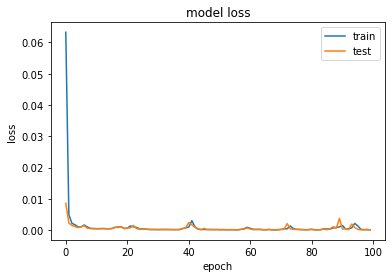

In [13]:
wave_py, wave_ty,wave_mse,wavemodel = DE_Learner(wave_dat,t1,t2)

140


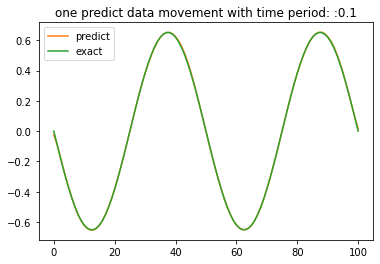

In [15]:
plt.figure()
print(len(wave_py))
plt.plot(range(101),wave_py[0],'C1',label = 'predict')
plt.plot(range(101),wave_ty[0],'C2', label = 'exact')
for i in range(1,1):
    plt.plot(range(101),wave_py[i],'C3')
    plt.plot(range(101),wave_ty[i],'C2')
plt.legend()
plt.title('one predict data movement with time period: :'+str(dt*t2))
plt.show()


#### 2D heat equation
$u_{t} = D(u_{xx}+u_{yy})$

Time series data size:  1600 1501
dt:  0.0006250000000000001


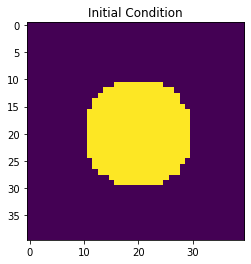

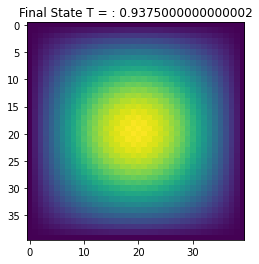

In [6]:
# plate size,

w = h = 2.
# intervals in x-, y- directions, mm
dx = dy = .05
# Thermal diffusivity of steel, mm2.s-1
D = 1.

Tcool, Thot = .1, .9

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

# Initial conditions - ring of inner radius r, width dr centred at (cx,cy) (mm)
r, cx, cy = .5, 1, 1
r2 = r**2
heat_dat = [[] for _ in range(int(nx*ny))]
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = Thot
k = 0
for i in range(nx):
    for j in range(ny):
        heat_dat[k].append(u0[i,j])
        k+= 1
plt.figure()
plt.imshow(u0)
plt.title('Initial Condition')
def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u
time_step = 1500
for steps in range(time_step):
    u0, u = do_timestep(u0, u)
    k = 0
    for i in range(nx):
        for j in range(ny):
            heat_dat[k].append(u0[i,j])
            k+= 1
plt.figure()
plt.imshow(u0)
plt.title('Final State T = : '+ str(dt*time_step))
print('Time series data size: ', len(heat_dat), len(heat_dat[0]))
print('dt: ',dt)

In [ ]:
t1, t2 = 30,10
print('training time period: ', dt*t1)
print('test time period: ', dt*t2)
heat_py, heat_ty, heat_mse, heatmodel = DE_Learner(heat_dat,t1,t2)

training time period:  0.018750000000000003
test time period:  0.006250000000000001
Whole data size(batch, row, column) (49, 1600, 30) (49, 1600, 10)
Train data size(batch, row, column) (39, 1600, 30) (39, 1600, 10)
test data size(batch, row, column) (10, 1600, 30) (10, 1600, 10)
Train on 31 samples, validate on 8 samples
Epoch 1/100
31/31 [==============================] - 8s 261ms/step - loss: 0.0101 - val_loss: 0.0019

In [ ]:
aa = [1,2,3,4]
aa[-2:]

In [ ]:
idx = random.randint(0, len(heat_ty)-1)
k = 0
print(idx)
v0 = np.ones((nx,ny))
u0 = np.ones((nx,ny))
for i in range(nx):
    for j in range(ny):
        v0[i,j] = heat_py[idx][k]
        u0[i,j] = heat_ty[idx][k]
        k+=1
plt.figure()
plt.imshow(v0)
plt.title('Test Data')
plt.figure()
plt.imshow(u0)
plt.title('Predicted Data')

### Nonlinear PDE
#### 2d Burgers Equation:
#### $\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} +v\frac{\partial u}{\partial y} = \nu(\frac{\partial^2 u}{\partial x^2} +\frac{\partial^2 u}{\partial y^2})$
#### $\frac{\partial v}{\partial t} + u\frac{\partial u}{\partial x} +v\frac{\partial u}{\partial y} = \nu(\frac{\partial^2 u}{\partial x^2} +\frac{\partial^2 u}{\partial y^2})$

c:\python37\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


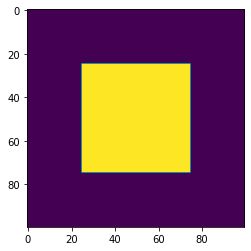

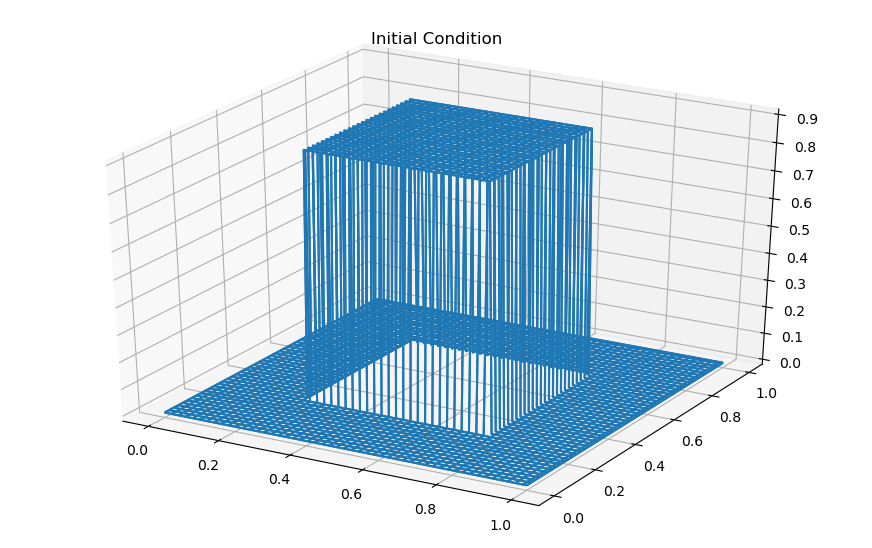

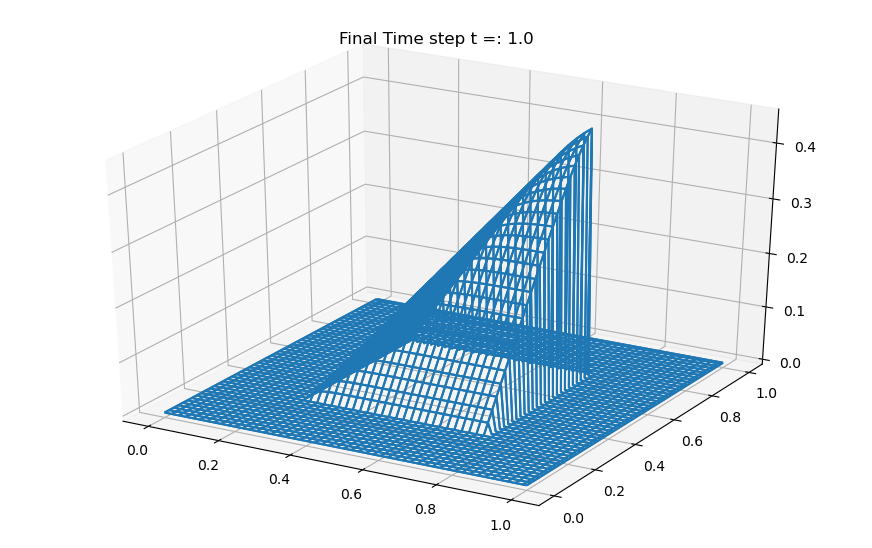

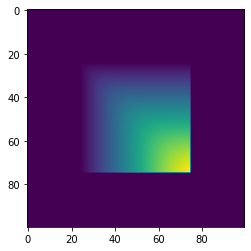

In [16]:
matplotlib.use ( 'Agg' )
width, height = 1., 1.
dx = dy = .01
nx = int(width/dx)
ny = int(height/dy)
nt = 1000
sigma = 10
nu = 0
dt = sigma * dx * dy #/ nu
x = np.linspace ( 0.0, width, nx )
y = np.linspace ( 0.0, height, ny )
X, Y = np.meshgrid ( x, y )
u = np.zeros ( ( ny, nx ) )
v = np.zeros ( ( ny, nx ) )
v[nx//4:nx//4*3,ny//4:ny//4*3] = .9
plt.figure()
plt.imshow(v)
u[:] =v
#plot the initial conditions
fig = plt.figure ( figsize = ( 11, 7 ), dpi = 100 )
ax = fig.gca ( projection = '3d' )
wire1 = ax.plot_wireframe ( X, Y, u[:], cmap = cm.coolwarm )
wire2 = ax.plot_wireframe ( X, Y, v[:], cmap = cm.coolwarm )
ax.set_title('Initial Condition')
#save the time series data:
u_dat = [[] for _ in range(nx*ny)]
v_dat = [[] for _ in range(nx*ny)]
k = 0
for i in range(ny):
    for j in range(nx):
        u_dat[k].append(u[i,j])
        v_dat[k].append(v[i,j])
        k+=1

for n in range ( nt + 1 ):
  un = u.copy ( )
  vn = v.copy ( )
  u[1:-1,1:-1] = un[1:-1,1:-1] \
    - dt / dx * un[1:-1,1:-1] * ( un[1:-1,1:-1] - un[1:-1,0:-2] ) \
    - dt / dy * vn[1:-1,1:-1] * ( un[1:-1,1:-1] - un[0:-2,1:-1] ) \
    + nu * dt / dx ** 2 * ( un[1:-1,2:] - 2 * un[1:-1,1:-1] + un[1:-1,0:-2] ) \
    + nu * dt / dy ** 2 * ( un[2:,1:-1] - 2 * un[1:-1,1:-1] + un[0:-2,1:-1] )
  v[1:-1,1:-1] = vn[1:-1,1:-1] \
    - dt / dx * un[1:-1,1:-1] * ( vn[1:-1,1:-1] - vn[1:-1,0:-2] ) \
    - dt / dy * vn[1:-1,1:-1] * ( vn[1:-1,1:-1] - vn[0:-2,1:-1] ) \
    + nu * dt / dx ** 2 * ( vn[1:-1,2:] - 2 * vn[1:-1,1:-1] + vn[1:-1,0:-2] ) \
    + nu * dt / dy ** 2 * ( vn[2:,1:-1] - 2 * vn[1:-1,1:-1] + vn[0:-2,1:-1] )
  u[0,:] = 0
  u[-1,:] = 0
  u[:,0] = 0
  u[:,-1] = 0
  v[0,:] = 0
  v[-1,:] = 0
  v[:,0] = 0
  v[:,-1] = 0
  k = 0
  for i in range(ny):
    for j in range(nx):
        u_dat[k].append(u[i,j])
        v_dat[k].append(v[i,j])
        k+=1
fig = plt.figure ( figsize = ( 11, 7 ), dpi = 100 )
ax = fig.gca ( projection = '3d' )
wire1 = ax.plot_wireframe ( X, Y, u )
wire2 = ax.plot_wireframe ( X, Y, v )
ax.set_title('Final Time step t =: '+str(dt*nt))
plt.show()
plt.figure()
plt.imshow(v)


In [17]:
print(len(u_dat), len(v_dat))

10000 10000


In [21]:
burgers_data = u_dat + v_dat
t1, t2 = 30,10
print('training time period: ', dt*t1)
print('test time period: ', dt*t2)
# To test the final state
print(len(burgers_data),len(burgers_data[0]))
final_x = [d[-t1-t2:-t2] for d in burgers_data]
final_y = [d[-t2:] for d in burgers_data]
final_x = np.array(final_x).reshape(1, len(final_x),len(final_x[0]))
final_y = np.array(final_y).reshape(1, len(final_y),len(final_y[0]))
burgers_data = [d[:-t1-t2] for d in burgers_data]
print(len(burgers_data),len(burgers_data[0]))

training time period:  0.03
test time period:  0.01
10000 1002
10000 962


10000


c:\python37\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


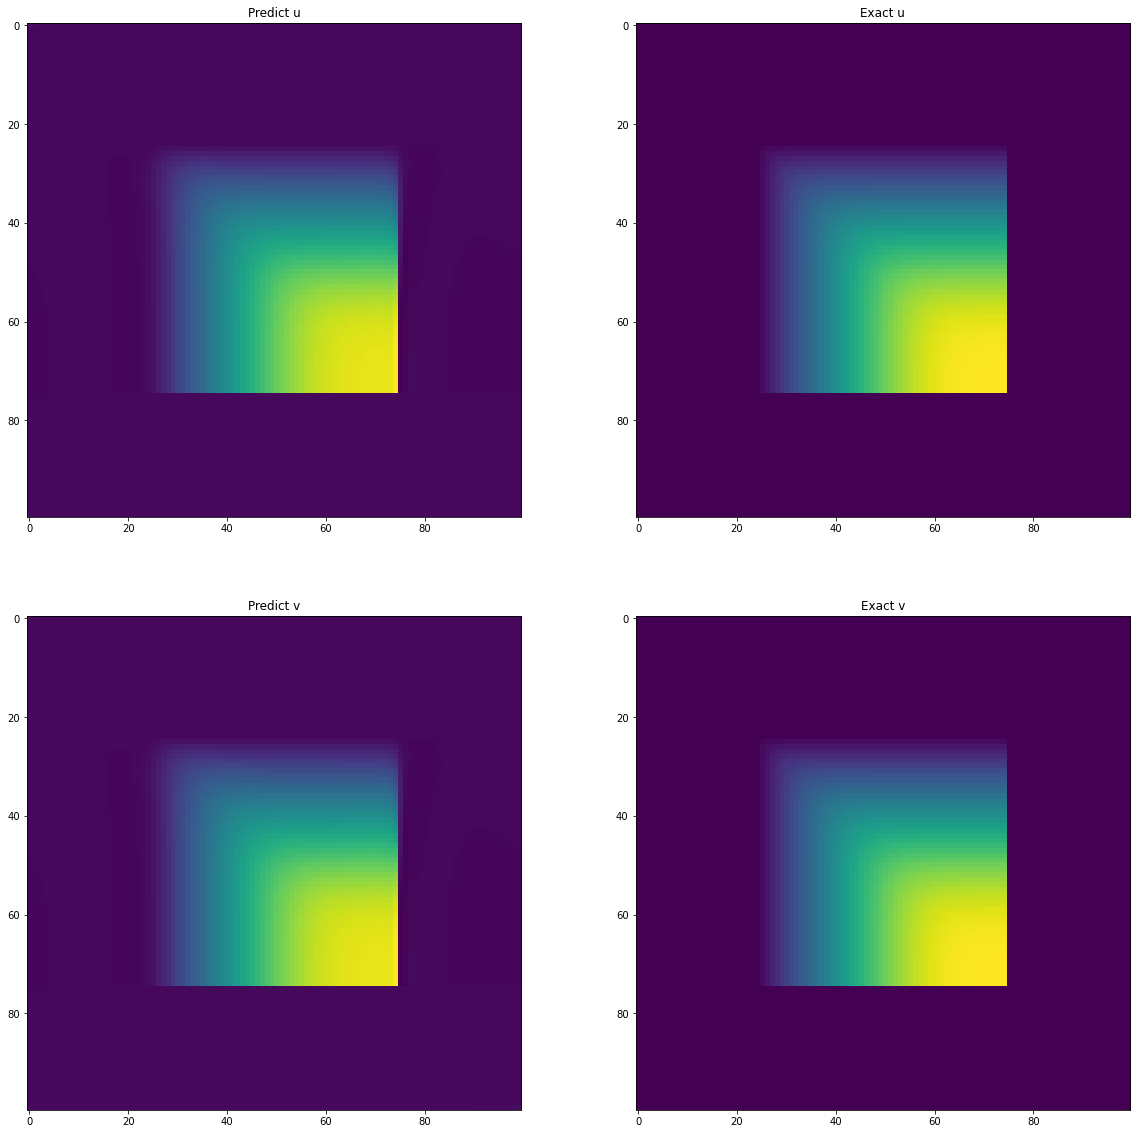

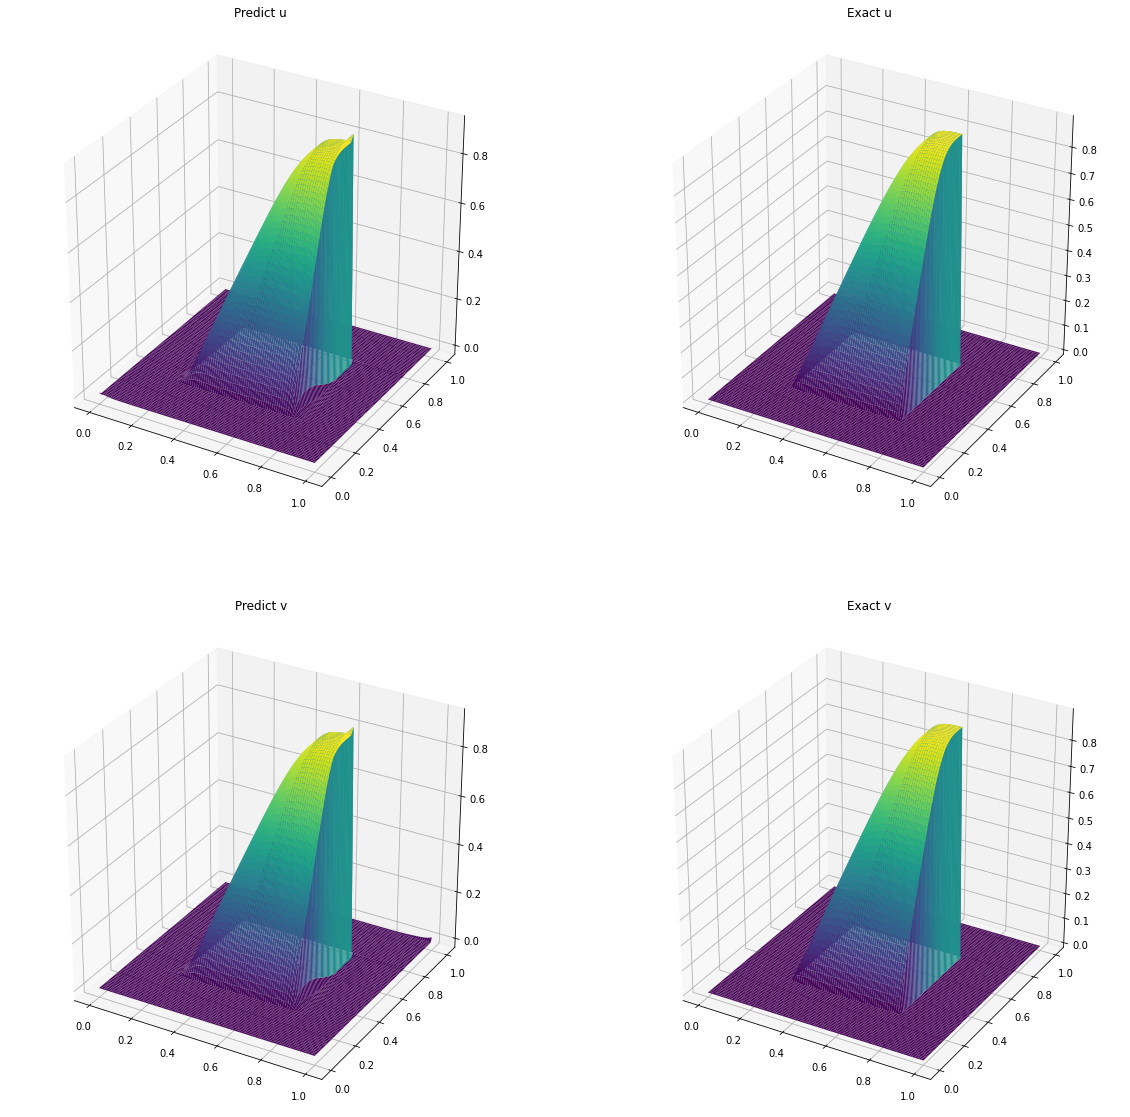

In [47]:
print(final_x.shape, final_y.shape)
burger_py, burger_ty, burger_err, burgermodel = DE_Learner(burgers_data, t1,t2)



In [48]:
final_pred = burgermodel.predict(final_x,verbose=1)
print(final_pred.shape)

1/1 [==============================] - 2s 2s/step
(1, 20000, 15)


In [49]:
final_py = flattern(final_pred)
final_ty = flattern(final_y)
final_py = np.array(final_py).T
final_ty = np.array(final_ty).T
k = 0
v0 = np.ones((ny,nx))
u0 = np.ones((ny,nx))
print(len(final_py),len(final_py[0]))
for i in range(nx):
    for j in range(ny):
        v0[i,j] = final_py[t2-1][k]
        u0[i,j] = final_ty[t2-1][k]
        k+=1

15 20000


Text(0.5, 1.0, 'Predicted Data at time: 1.0')

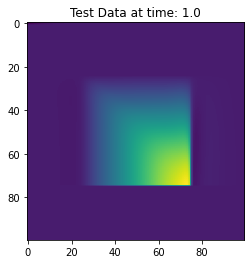

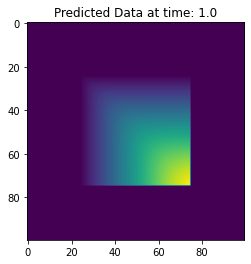

In [50]:
plt.figure()
plt.imshow(v0)
plt.title('Test Data at time: '+str(dt*nt))
plt.figure()
plt.imshow(u0)
plt.title('Predicted Data at time: '+str(dt*nt))

final steps error:  2.7002465627040675e-05


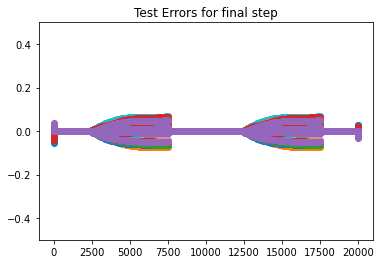

In [51]:
final_mse = []
for j in range(len(final_py)):
    final_mse.append(mean_squared_error(final_py[j],final_ty[j]))
    plt.scatter(range(len(final_py[j])),[final_ty[j][i]-final_py[j][i] for i in range(len(final_py[j]))])
plt.title('Test Errors for final step')
plt.ylim(-.5,.5)
print('final steps error: ', np.mean(final_mse))

Text(0.5, 0.92, 'Predicted Data at time: 1.0')

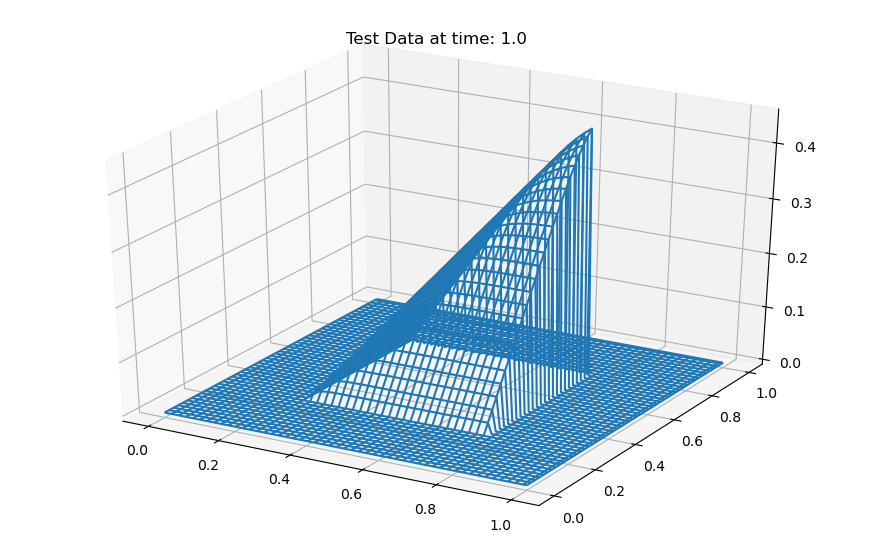

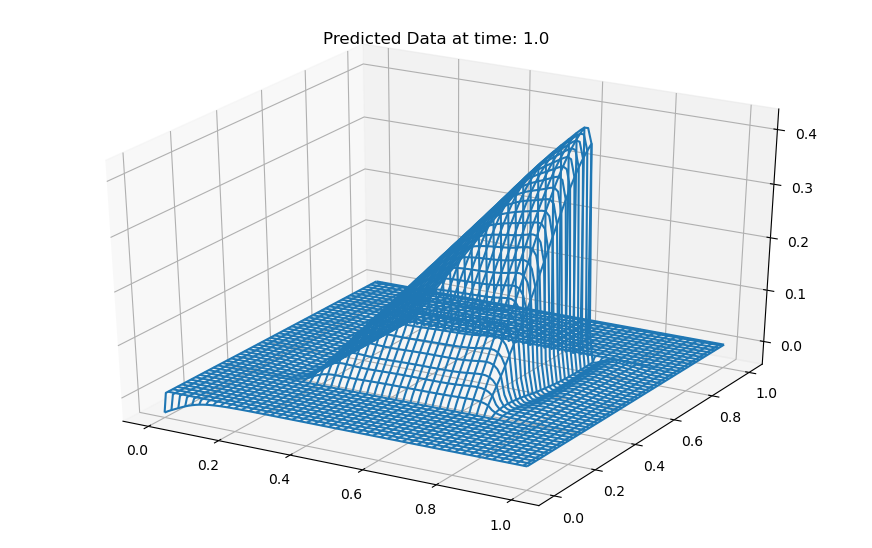

In [52]:
fig = plt.figure ( figsize = ( 11, 7 ), dpi = 100 )
ax = fig.gca ( projection = '3d' )
wire1 = ax.plot_wireframe ( X, Y, u0[:], cmap = cm.coolwarm )
ax.set_title('Test Data at time: '+str(dt*nt))
fig = plt.figure ( figsize = ( 11, 7 ), dpi = 100 )
ax = fig.gca ( projection = '3d' )
wire1 = ax.plot_wireframe ( X, Y, v0[:], cmap = cm.coolwarm )
ax.set_title('Predicted Data at time: '+str(dt*nt))

#### A coupled PDE system: Cahn - Hilliard Naiver Stokes Equation
\begin{align*}
&u_{t} +u \cdot \nabla u
= -\nabla p + \nu \Delta u  - \phi  \nabla \mu \\
    &\phi_t{} + \nabla \cdot (u\phi) = M\Delta \mu \\
    &\mu = \lambda(-\Delta\phi + \frac{\phi}{\eta^2}( \phi^2-1))
\end{align*}
#### The data is simulated by a Crank Nicolson based Finite Element Scheme

In [56]:
file_name = 'C:/Users/yihao/Dropbox/Research/DL_PDE/Data/code/cahn_hilliard_ns/'
phi =[[] for _ in range(4385)]
p =[[] for _ in range(4385)]
u1 = [[] for _ in range(4385)]
u2 = [[] for _ in range(4385)]
data_len = 2000
for frame in range(1, data_len):
    f1 = open(file_name + 'movie_phi_'+str(10000+frame)+'.txt')
    f2 = open(file_name + 'movie_pressuer_'+str(10000+frame)+'.txt')
    f3 = open(file_name + 'movie_u1_'+str(10000+frame)+'.txt')
    f4 = open(file_name + 'movie_u2_'+str(10000+frame)+'.txt')
    lines1 = f1.readlines()
    lines2 = f2.readlines()
    lines3 = f3.readlines()
    lines4 = f4.readlines()
    #print(len(lines1),len(lines2),len(lines3),len(lines4))
    for i in range(len(phi)):
        phi[i].append(float(lines1[i].strip()))
        p[i].append(float(lines2[i].strip()))
        u1[i].append(float(lines3[i].strip()))
        u2[i].append(float(lines4[i].strip()))

c:\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  import sys


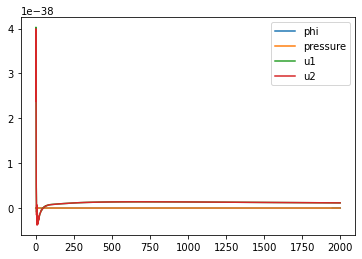

In [57]:
plt.figure()
plt.plot(phi[0])
plt.plot(p[0])
plt.plot(u1[0])
plt.plot(u2[0])
plt.legend(['phi','pressure','u1','u2'])
plt.show()

In [67]:
system = phi
#system = data_normalize(system)
t1 = 10; t2 = 5

In [68]:
#select last data for prediction plot
print(len(system),len(system[0]))
sys_final_x = [d[-t1-t2:-t2] for d in system]
sys_final_y = [d[-t2:] for d in system]
sys_final_x = np.array(sys_final_x).reshape(1, len(sys_final_x),len(sys_final_x[0]))
sys_final_y = np.array(sys_final_y).reshape(1, len(sys_final_y),len(sys_final_y[0]))
system = [d[:-t1-t2] for d in system]
print(len(system),len(system[0]))


4385 1999
4385 1984


Whole data size(batch, row, column) (197, 4385, 10) (197, 4385, 5)
Train data size(batch, row, column) (157, 4385, 10) (157, 4385, 5)
test data size(batch, row, column) (40, 4385, 10) (40, 4385, 5)
Train on 125 samples, validate on 32 samples
Epoch 1/100
125/125 [==============================] - 106s 845ms/step - loss: 0.0109 - val_loss: 0.0035

c:\python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
c:\python37\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
c:\python37\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


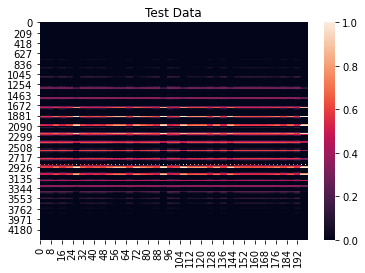

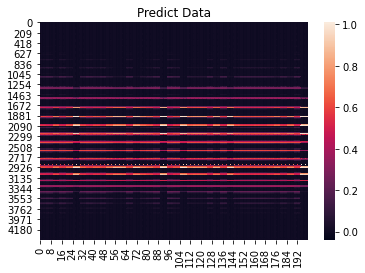

<Figure size 432x288 with 0 Axes>

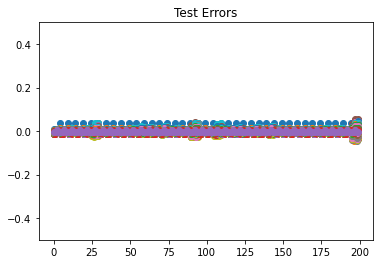

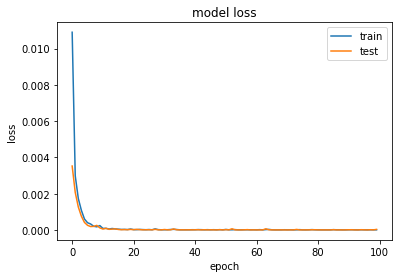

In [69]:
system_py, system_ty, system_err, systemmodel = DE_Learner(system, t1,t2)


In [ ]:
sys_final_py = systemmodel.predict(sys_final_x)
print(sys_final_py.shape)
system_data_py = flattern(sys_final_py)
system_data_ty = flattern(sys_final_y)
system_data_py = np.array(system_data_py).T
system_data_ty = np.array(system_data_ty).T
system_data_py = system_py
system_data_ty = system_ty
print(len(system_data_py),len(system_data_py[0]))
idx = random.randint(0, len(system_data_ty)-1)
pred_phi = system_data_py[idx]
test_phi = system_data_ty[idx]
fa=open('pred_phi.txt','w')
fb=open('test_phi.txt','w')
for i in range(len(pred_phi)):
    fa.write(str(pred_phi[i])+'\n')
    fb.write(str(test_phi[i])+'\n')
fa.close()
fb.close()

In [ ]:
system_data_py, system_data_ty = system_py, system_ty

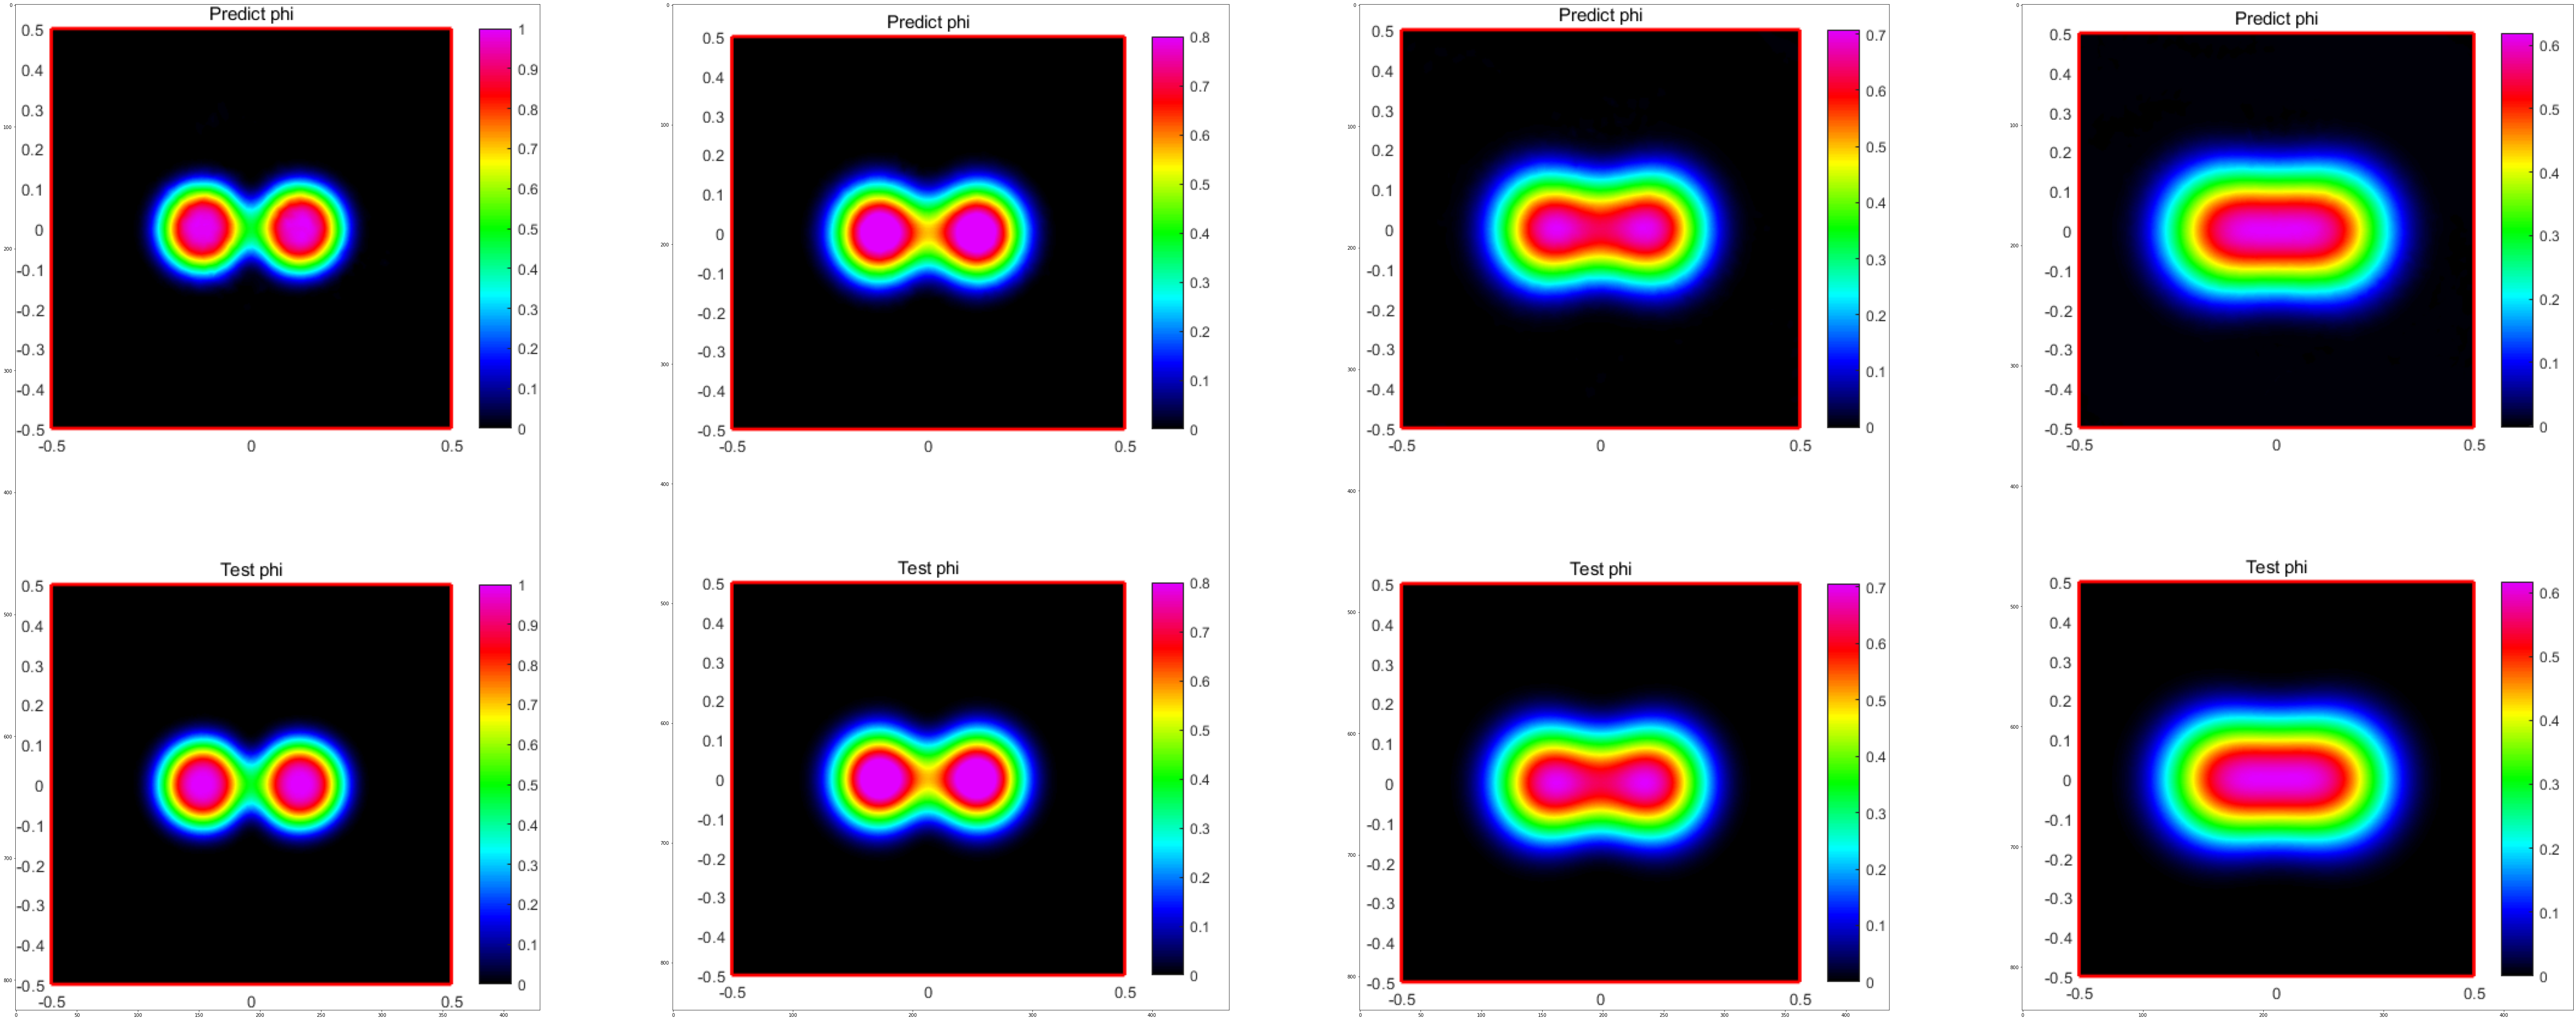

In [10]:
img1 = mpimg.imread('1.1.png')
img2 = mpimg.imread('1.2.png')
img3 = mpimg.imread('1.3.png')
img4 = mpimg.imread('1.4.png')
plt.figure(figsize=(100, 40))
plt.subplot(141)
plt.imshow(img1)
plt.subplot(142)
plt.imshow(img2)
plt.subplot(143)
plt.imshow(img3)
plt.subplot(144)
plt.imshow(img4)
plt.show()
# print(len(system_data_py),len(system_data_py[0]))
# idx = random.randint(0, len(system_data_ty)-1)
# pred_phi = system_data_py[idx][:4385]
# pred_p = system_data_py[idx][4385:4385*2]
# pred_u1 = system_data_py[idx][4385*2:4385*3]
# pred_u2 = system_data_py[idx][-4385:]
# test_phi = system_data_ty[idx][:4385]
# test_p = system_data_ty[idx][4385:4385*2]
# test_u1 = system_data_ty[idx][4385*2:4385*3]
# test_u2 = system_data_ty[idx][-4385:]
# fig = plt.figure()
# ax1 = fig.add_subplot(221)
# ax1.plot(range(4385),pred_phi)
# ax1.plot(range(4385),test_phi)
# ax1.legend(['predicted phi','Test Phi'])
# ax2 = fig.add_subplot(222)
# ax2.plot(range(4385),pred_p)
# ax2.plot(range(4385),test_p)
# ax2.legend(['predicted p','Test p'])
# ax3 = fig.add_subplot(223)
# ax3.plot(range(4385),pred_u1)
# ax3.plot(range(4385),test_u1)
# ax3.legend(['predicted u1','Test u1'])
# ax4 = fig.add_subplot(224)
# ax4.plot(range(4385),pred_u2)
# ax4.plot(range(4385),test_u2)
# ax4.legend(['predicted u2','Test u2'])
# plt.show()
# plt.plot(pred_u1[i] - test_u1[i] for i in range(4385))
# plt.ylim(1e-3)
# f11=open('pred_phi.txt','w')
# f12=open('test_phi.txt','w')
# f21=open('pred_p.txt','w')
# f22=open('test_p.txt','w')
# f31=open('pred_u1.txt','w')
# f32=open('test_u1.txt','w')
# f41=open('pred_u2.txt','w')
# f42=open('test_u2.txt','w')
# for i in range(len(pred_p)):
#     f11.write(str(pred_phi[i])+'\n')
#     f12.write(str(test_phi[i])+'\n')
#     f21.write(str(pred_p[i])+'\n')
#     f22.write(str(test_p[i])+'\n')
#     f31.write(str(pred_u1[i])+'\n')
#     f32.write(str(test_u1[i])+'\n')
#     f41.write(str(pred_u2[i])+'\n')
#     f42.write(str(test_u2[i])+'\n')
# f11.close()
# f12.close()
# f21.close()
# f22.close()
# f31.close()
# f32.close()
# f41.close()
# f42.close();                                                                                                                           close()

#### Rayleigh-Bénard Convection

In [116]:
file_name = 'C:/Users/Alienware/Dropbox/Research/DL_PDE/Data/Example/convective_rolls/'
grid = 4197
temp =[[] for _ in range(grid)]
u1 = [[] for _ in range(grid)]
u2 = [[] for _ in range(grid)]
data_len = 2000
for frame in range(1, data_len):
    f1 = open(file_name + 'convective_rolls_temp_'+str(10000+frame)+'.txt')
    f2 = open(file_name + 'convective_rolls_u1_'+str(10000+frame)+'.txt')
    f3 = open(file_name + 'convective_rolls_u2_'+str(10000+frame)+'.txt')
    lines1 = f1.readlines()
    lines2 = f2.readlines()
    lines3 = f3.readlines()
    #print(len(lines1),len(lines2),len(lines3),len(lines4))
    for i in range(len(temp)):
        temp[i].append(float(lines1[i].strip()))
        u1[i].append(float(lines2[i].strip()))
        u2[i].append(float(lines3[i].strip()))

0


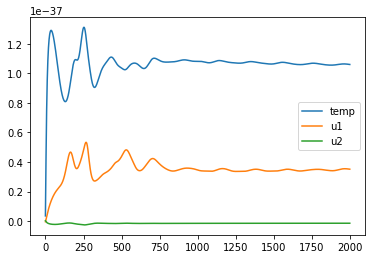

In [117]:
print(sum([sum(np.isnan(d)) for d in temp]))
plt.figure()
plt.plot(temp[2])
plt.plot(u1[0])
plt.plot(u2[0])
plt.legend(['temp','u1','u2'])
plt.show()

In [122]:
#select last data for prediction plot
#temp = data_normalize(temp)
Convec_rolls = temp[:200]
#system = data_normalize(system)
t1 = 30; t2 = 30
print(len(Convec_rolls),len(Convec_rolls[0]))
sys_final_x = [d[-t1-t2:-t2] for d in Convec_rolls]
sys_final_y = [d[-t2:] for d in Convec_rolls]
sys_final_x = np.array(sys_final_x).reshape(1, len(sys_final_x),len(sys_final_x[0]))
sys_final_y = np.array(sys_final_y).reshape(1, len(sys_final_y),len(sys_final_y[0]))
Convec_rolls = [d[:-t1-t2] for d in Convec_rolls]
print(len(Convec_rolls),len(Convec_rolls[0]))

200 1999
200 1939


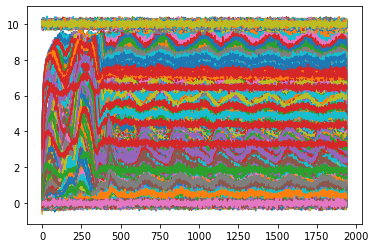

In [114]:
for c in Convec_rolls:
    plt.plot(c)

In [ ]:
sum(aaa)

In [123]:
Convec_rolls_py, Convec_rolls_ty, Convec_rolls_err, Convec_rollsmodel = DE_Learner(Convec_rolls, t1,t2)



Whole data size(batch, row, column) (63, 200, 30) (63, 200, 30)
Train data size(batch, row, column) (50, 200, 30) (50, 200, 30)
test data size(batch, row, column) (13, 200, 30) (13, 200, 30)
Train on 40 samples, validate on 10 samples
Epoch 1/100
35/40 [=========================>....] - ETA: 1s - loss: 30938539208711848.0000 

KeyboardInterrupt: 